The below Python script uses the Python API of Google Earth Engine to query and process satellite data, here Sentinel-2. The MSAVI-2 index for all the images in the collection is computed using the formula proposed by Qi et al. (1994, Equation 19).

**Note: To quickly run this script in Google Colab, simply add 'tocolab' just after github in the above URL address.**

In [ ]:
import ee
from IPython.display import Image, display
from matplotlib import pyplot as plt

In [ ]:
ee.Authenticate()
ee.Initialize()

In [ ]:
# Define the AOI
aoi1 = ee.Geometry.Polygon([[[75.4515749216079,30.6344041299044],\
                               [75.4524278640747,30.6337209980438],\
                               [75.4523688554763,30.6343995141647],\
                               [75.4515749216079,30.6344041299044]]])

aoi2 = ee.Geometry.Polygon([[[85.85622847080231,26.09425078918021],\
                               [85.85590660572052,26.093581136401006],\
                               [85.85663080215454,26.09337879451938 ],\
                               [85.85686147212981,26.094009907326967],\
                               [85.85622847080231,26.09425078918021]]])

aoi3 = ee.Geometry.Polygon([[[78.66571158170699,17.66869116558751],\
                               [78.6662346124649,17.6686911655875],\
                               [78.6662346124649,17.66929686130703],\
                               [78.66571158170699,17.66929686130703],\
                               [78.66571158170699,17.66869116558751]]])

aoi_dict = {'AOI-1':aoi1, 'AOI-2':aoi2, 'AOI-3':aoi3}
print([('Area of '+key,aoi_dict[key].area().getInfo()) for key in aoi_dict.keys()])


def get_image_collection(aoi):
  # Create the Sentinel-2 collection
  s2_collection = ee.ImageCollection('COPERNICUS/S2_SR')\
                    .filterDate('2020-01-01', '2020-07-01')\
                    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',30))\
                    .filterBounds(aoi)
  return(s2_collection)

# Display the composite of the collection
aoi = 'AOI-1'
display(Image(url = get_image_collection(aoi_dict[aoi]).mosaic().clip(aoi_dict[aoi]).getThumbURL({'min': 100, 'max': 1500, 'bands': ['B8', 'B3', 'B2'], 'dimensions': 256})))


[('Area of AOI-1', 2864.0747241731956), ('Area of AOI-2', 5580.62649238127), ('Area of AOI-3', 3732.211087402558)]


In [ ]:
# define a function to compute average MSAVI-2 for each image
def compute_msavi2(image):
  nir = image.select('B8')
  red = image.select('B4')
  
  # Compute the MSAVI-2 index
  under_root = nir.multiply(2).add(1).pow(2).subtract(nir.subtract(red).multiply(8)).pow(0.5)
  msavi2 = nir.multiply(2).add(1).subtract(under_root).rename('msavi2')

  # Compute the mean of the MSAVI for the region
  mean_msavi2 = msavi2.reduceRegion(ee.Reducer.mean(), aoi_dict[aoi], 10)

  mean_msavi2 = mean_msavi2.getInfo()['msavi2']
  #msavi2 = msavi2.set('mean', mean_msavi2) # if band is also required
  
  return(mean_msavi2)

# define a function to get the date and the MSAVI-2 as two separate lists
def get_date_msavi2(aoi):
  # create colleaction for the aoi
  s2_collection = get_image_collection(aoi_dict[aoi])

  # create a list of dates in the collection
  dates_list = ee.List(s2_collection.aggregate_array('system:time_start')).map(lambda time_start:ee.Date(time_start)).getInfo()
  mean_list = []

  # loop through each date, filter the collection and then compute MSAVI-2 for each date
  for date in dates_list:
    current_image = s2_collection.filter(ee.Filter.date(ee.Date(date['value']), ee.Date(date['value']).advance(1, 'day'))).mosaic()
    mean_list.append(compute_msavi2(current_image))

  # format the date from ee.Date type to readable string type
  dates_list = [ee.Date(date['value']).format('Y-MM-dd').getInfo() for date in dates_list]

  return(dates_list, mean_list)

date_dict = dict()
mean_dict = dict()
for aoi in aoi_dict.keys():
  print('Computing for', aoi)
  date_dict[aoi], mean_dict[aoi] = get_date_msavi2(aoi)

Computing for AOI-1
Computing for AOI-2
Computing for AOI-3


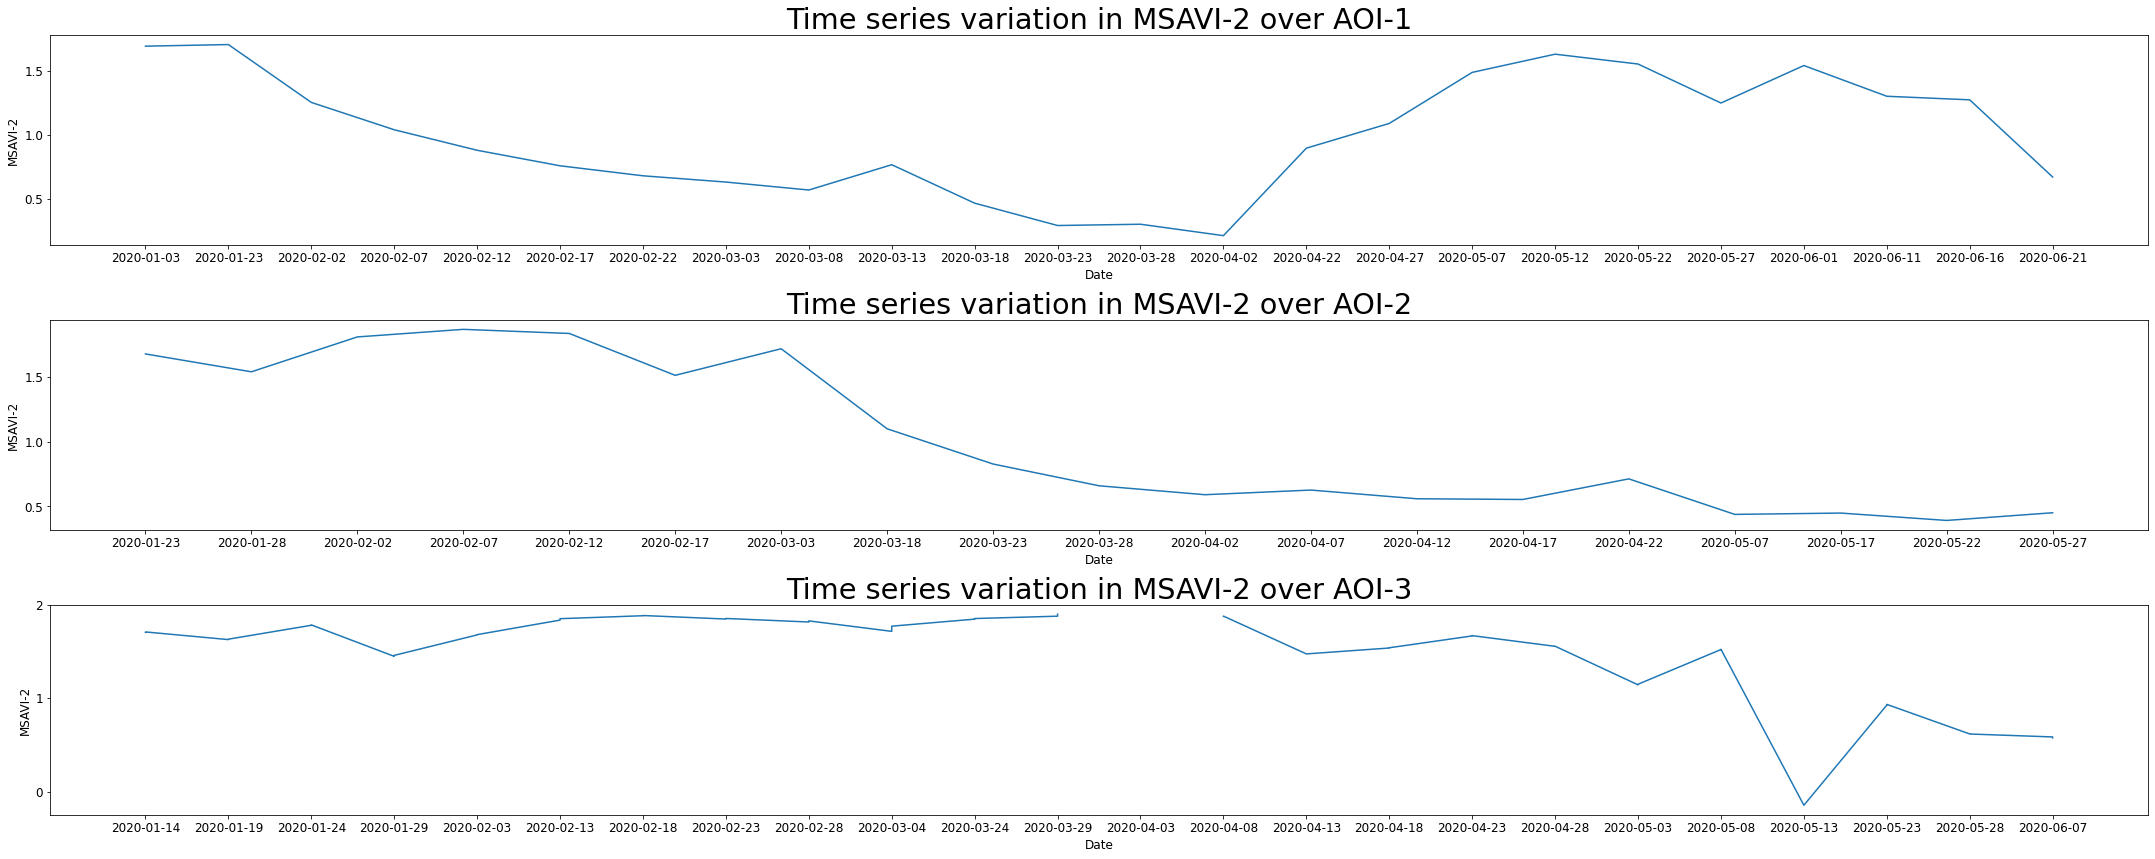

In [ ]:
fig, ax = plt.subplots(len(aoi_dict), 1)
plt.rcParams['font.size'] = '24'

n = 0
for aoi in aoi_dict.keys():
  ax[n].set_title('Time series variation in MSAVI-2 over %s' % aoi)
  ax[n].plot(date_dict[aoi], mean_dict[aoi])
  ax[n].set(xlabel='Date', ylabel='MSAVI-2')
  n += 1
fig.set_figheight(12)
fig.set_figwidth(30)
fig.tight_layout(pad=0.4)
plt.show()